# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models, evaluate
from importlib import reload
reload(import_preprocess)
reload(baseline_models)
reload(evaluate)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()

X_train, y_train, S_train = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train
X_val, y_val, S_val = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val
X_test, y_test, S_test = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test
X_balanced, y_balanced = import_preprocess.create_balanced_dataset(X_train, y_train, n_samples=5000)

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


In [3]:
# import_preprocess.convert_class_labels()
# y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [4]:
#X_train_dev, y_train_val = import_preprocess.concatenate_train_val()
#len(X_train_dev)
S_train[1]

'This is like the Metallica video where the poor mutilated bastard was saying "Please kill me" over and over again, only with emojis instead of Morse code.'

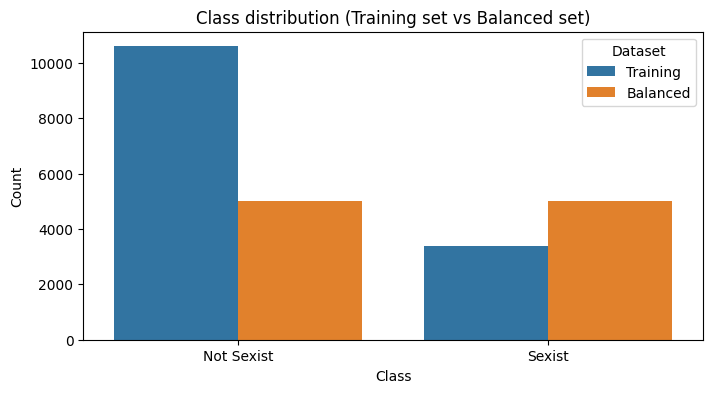

In [5]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



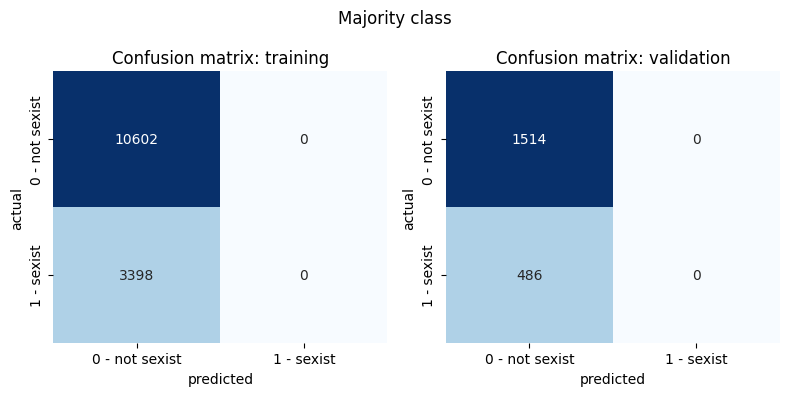

In [7]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



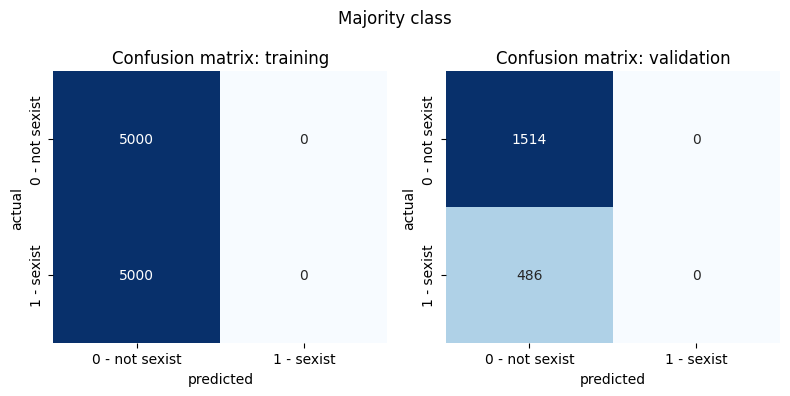

In [8]:
majority_class_classifier.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

2. regex classifier

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8167
balanced accuracy: 0.6664
precision: 0.7430
recall: 0.3743

########################################

Metrics for validation
accuracy: 0.7975
balanced accuracy: 0.6301
precision: 0.6884
recall: 0.3045

########################################



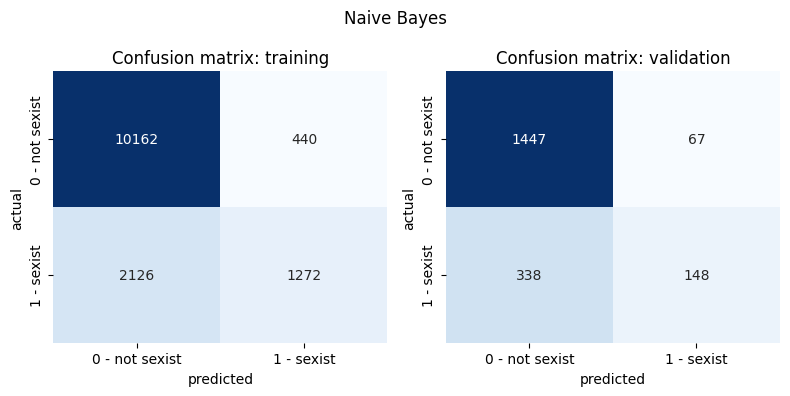

In [9]:
X_train_bow, X_val_bow, X_test_bow, X_balanced_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.5633
balanced accuracy: 0.5633
precision: 0.5609
recall: 0.5828

########################################

Metrics for validation
accuracy: 0.4865
balanced accuracy: 0.4960
precision: 0.2402
recall: 0.5144

########################################



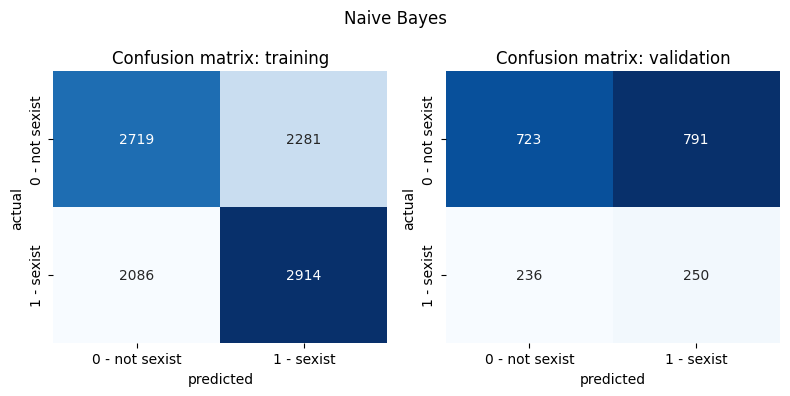

In [10]:
naive_bayes_classifier.train(X_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier.evaluate({"training": X_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8218
balanced accuracy: 0.6630
precision: 0.8000
recall: 0.3543

########################################

Metrics for validation
accuracy: 0.8045
balanced accuracy: 0.6271
precision: 0.7654
recall: 0.2819

########################################



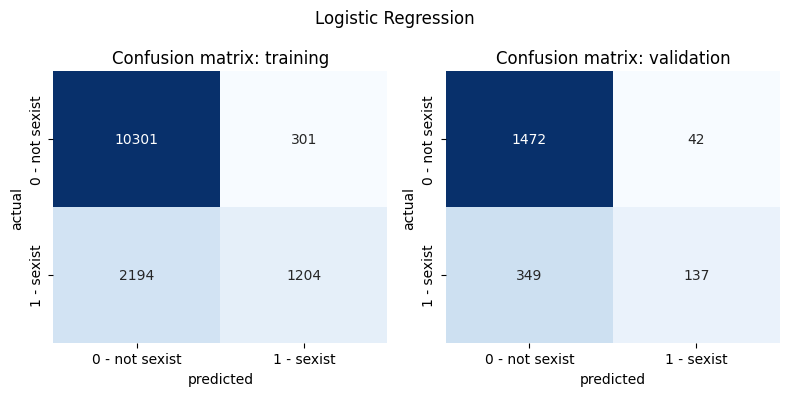

In [11]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.5652
balanced accuracy: 0.5652
precision: 0.5614
recall: 0.5960

########################################

Metrics for validation
accuracy: 0.4930
balanced accuracy: 0.5031
precision: 0.2452
recall: 0.5226

########################################



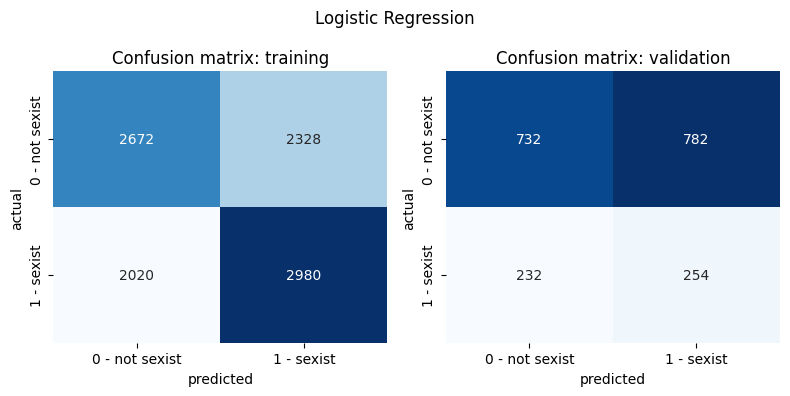

In [12]:
log_reg_classifier.train(X_balanced_bow, y_balanced, None, None)

res = log_reg_classifier.evaluate({"training": X_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.53193	eval-logloss:0.53723
[1]	train-logloss:0.51431	eval-logloss:0.52352
[2]	train-logloss:0.50007	eval-logloss:0.51216
[3]	train-logloss:0.48820	eval-logloss:0.50334
[4]	train-logloss:0.47855	eval-logloss:0.49671
[5]	train-logloss:0.47021	eval-logloss:0.49069
[6]	train-logloss:0.46321	eval-logloss:0.48565
[7]	train-logloss:0.45708	eval-logloss:0.48162
[8]	train-logloss:0.45157	eval-logloss:0.47800
[9]	train-logloss:0.44715	eval-logloss:0.47518
[10]	train-logloss:0.44303	eval-logloss:0.47317
[11]	train-logloss:0.43920	eval-logloss:0.47105
[12]	train-logloss:0.43602	eval-logloss:0.46948
[13]	train-logloss:0.43282	eval-logloss:0.46714
[14]	train-logloss:0.43031	eval-logloss:0.46602
[15]	train-logloss:0.42782	eval-logloss:0.46496
[16]	train-logloss:0.42549	eval-logloss:0.46407
[17]	train-logloss:0.42322	eval-logloss:0.46317
[18]	train-logloss:0.42098	eval-logloss:0.46199
[19]	train-logloss:0.41915	eval-logloss:0.46103
[20]	train-logloss:0.41745	eval-logloss:0.46053
[2

c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


########################################

Metrics for training
accuracy: 0.8459
balanced accuracy: 0.6908
precision: 0.9416
recall: 0.3893

########################################

Metrics for validation
accuracy: 0.7995
balanced accuracy: 0.6126
precision: 0.7707
recall: 0.2490

########################################



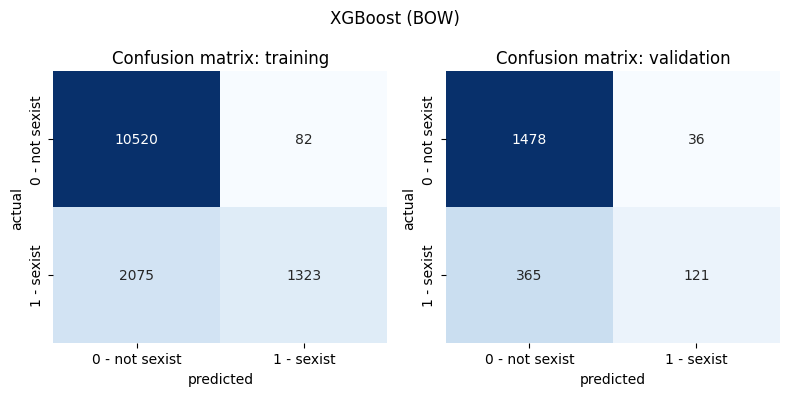

In [13]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.69109	eval-logloss:0.69330
[1]	train-logloss:0.68920	eval-logloss:0.69401
[2]	train-logloss:0.68754	eval-logloss:0.69423
[3]	train-logloss:0.68603	eval-logloss:0.69398
[4]	train-logloss:0.68477	eval-logloss:0.69412
[5]	train-logloss:0.68289	eval-logloss:0.69396
[6]	train-logloss:0.68164	eval-logloss:0.69408
[7]	train-logloss:0.67998	eval-logloss:0.69414
[8]	train-logloss:0.67863	eval-logloss:0.69422
[9]	train-logloss:0.67716	eval-logloss:0.69453
########################################

Metrics for training


c:\Users\jogip\OneDrive - TU Wien\Master\Natural Language Processing\NLP_24W_VSHJ\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy: 0.6029
balanced accuracy: 0.6029
precision: 0.5700
recall: 0.8382

########################################

Metrics for validation
accuracy: 0.3750
balanced accuracy: 0.4964
precision: 0.2412
recall: 0.7325

########################################



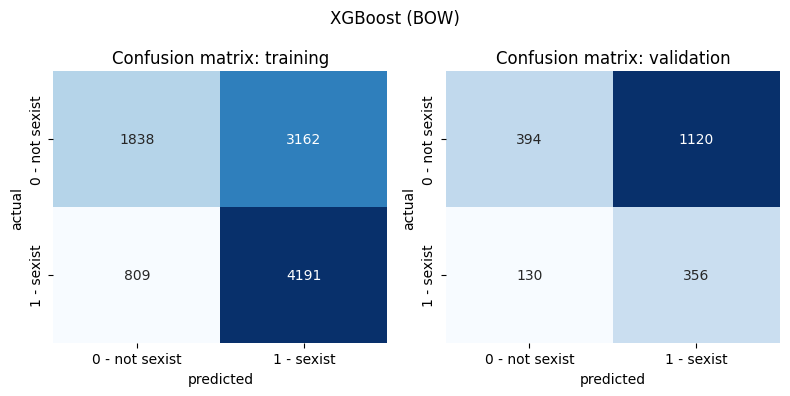

In [14]:
xg_boost_bow.train(X_balanced_bow, y_balanced, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (word embeddings representation)

#### b) DL baseline models

1. LSTM

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7552 - loss: 0.5629 - val_accuracy: 0.7565 - val_loss: 0.5575
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7502 - loss: 0.5468 - val_accuracy: 0.7815 - val_loss: 0.5045
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8100 - loss: 0.4652 - val_accuracy: 0.8115 - val_loss: 0.4491
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8445 - loss: 0.3903 - val_accuracy: 0.8010 - val_loss: 0.4613
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8783 - loss: 0.3271 - val_accuracy: 0.8230 - val_loss: 0.4425
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8964 - loss: 0.2797 - val_accuracy: 0.8175 - val_loss: 0.4917
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9090 - loss: 0.2571 - val_accuracy: 0.8340 - val_loss: 0.4180
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9175 - loss: 0.2434 - val_accuracy: 0.

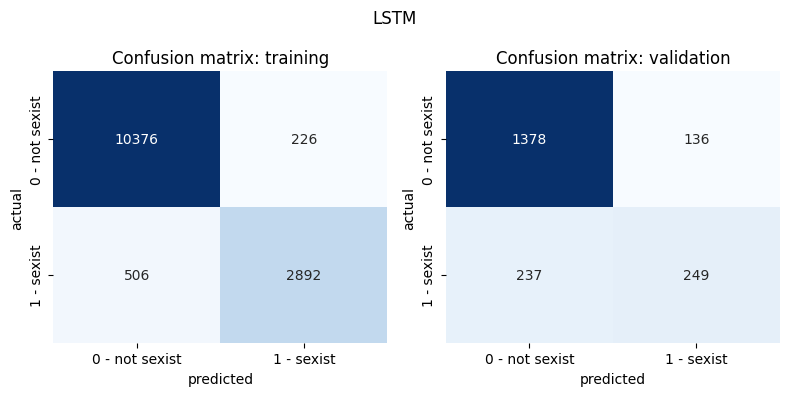

In [15]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4996 - loss: 0.6940 - val_accuracy: 0.7565 - val_loss: 0.6846
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4980 - loss: 0.6935 - val_accuracy: 0.7570 - val_loss: 0.6901
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5004 - loss: 0.6933 - val_accuracy: 0.7555 - val_loss: 0.6916
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.2430 - val_loss: 0.7040
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5530 - loss: 0.6771 - val_accuracy: 0.7315 - val_loss: 0.6229
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7609 - loss: 0.5312 - val_accuracy: 0.7805 - val_loss: 0.4952
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8638 - loss: 0.3551 - val_accuracy: 0.5455 - val_loss: 0.7037
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9028 - loss: 0.2718 - val_accuracy: 0.

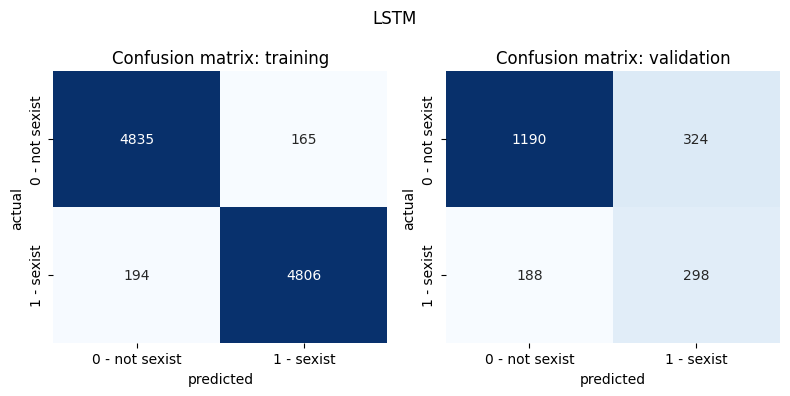

In [16]:
rnn.train(X_balanced, y_balanced, X_val, y_val)
res = rnn.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

## Results

In [17]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.816714,0.666418,0.742991,0.374338
3,Naive Bayes,validation,0.797500,0.630137,0.688372,0.304527
4,Logistic Regression,training,0.821786,0.662968,0.800000,0.354326
5,Logistic Regression,validation,0.804500,0.627076,0.765363,0.281893
6,XGBoost (BOW),training,0.845929,0.690806,0.941637,0.389347
7,XGBoost (BOW),validation,0.799500,0.612597,0.770701,0.248971
8,LSTM,training,0.947714,0.914886,0.927518,0.851089
9,LSTM,validation,0.813500,0.711259,0.646753,0.512346


In [18]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.5633,0.563300,0.560924,0.582800
3,Naive Bayes,validation,0.4865,0.495973,0.240154,0.514403
4,Logistic Regression,training,0.5652,0.565200,0.561417,0.596000
5,Logistic Regression,validation,0.4930,0.503061,0.245174,0.522634
6,XGBoost (BOW),training,0.6029,0.602900,0.569971,0.838200
7,XGBoost (BOW),validation,0.3750,0.496374,0.241192,0.732510
8,LSTM,training,0.9641,0.964100,0.966807,0.961200
9,LSTM,validation,0.7440,0.699583,0.479100,0.613169


In [19]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [20]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['sexist'], dtype='<U10'),
 'Logistic Regression': array(['sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['sexist'],
 'LSTM': 'not sexist'}

In [21]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


["aim for the head so she dosn't come back",
 "This guys gonna have a great time in the barracks. If they don't know who he is, they will the first time he takes a communal shower. Christ, the women Marines will even be giving him shit. Ooorah! Fuckin-A.",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 'Sheâ\x80\x99s unstable, youâ\x80\x99ll never know when she might dump you or cuck you for the ugliest thug in the nearest gang.',
 'A woman needs a man like a fish needs a bicycle!Â¹ ----- Â¹assuming fish spend half their life dreaming about finding the perfect bicycle',
 "I've only known 2 or 3 men in my entire life that micro managed their wives, girlfriends. It's exhausting and not worth it and most men are not that tiny, tiny minded, spiteful, hate filled and petty like a woman's mind is.",
 'Just block her, the da